In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/STAT8021_QA_Project')

Mounted at /content/drive


In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 5.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [4]:
import sys

import warnings
warnings.filterwarnings("ignore")

import os.path
import numpy as np
import pandas as pd
import re

#from newsqa import NewsQaExample, NewsQaModel, create_dataset, get_single_prediction
import utils
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,matthews_corrcoef
from transformers import AutoModel, AutoTokenizer, AutoModelForQuestionAnswering
from sklearn.model_selection import train_test_split
import gc
import random
from transformers import TrainingArguments, Trainer
from transformers import default_data_collator
import collections
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(2024)

In [13]:
# Loading the data
NEWS_STORIES = utils.open_pickle('data/news_stories.pkl')
news_data = pd.read_csv('data/newsqa-dataset-cleaned.csv')
total_examples = len(news_data)
print(total_examples)

87810


In [14]:
# Map the news text based on the story_id
news_data['story_text'] = news_data['story_id'].map(NEWS_STORIES)

In [15]:
# Create an empty list to store the answers
answers = []

# Iterate over each row in the dataframe
for idx, row in news_data.iterrows():
    start_truth = row['start_idx']
    end_truth = row['end_idx']
    story_text = row['story_text']

    # Extract the answer
    answer = story_text[start_truth:end_truth]
    # Append the answer to the list
    answers.append(answer)


news_data['answer'] = answers

In [16]:
# Get sample
data = news_data.sample(50000, random_state = 2024)

In [18]:
# Create an empty list to store the combined values
combined_values = [[(row['start_idx'], row['end_idx'])] for idx, row in data.iterrows()]
data['start-end'] = combined_values
data['narrowed_context'] = data['story_text']

In [20]:
#Select required field for trainning
df_filtered = data[['question','narrowed_context','start-end','answer']]

In [24]:
# Set empty ans = [-1,-1]
cleaned_values = [[row['answer']] if (row['start-end'] != (-1, -1)) else [] for idx, row in df_filtered.iterrows()]
df_filtered['answer'] = cleaned_values

In [25]:
df_filtered.head(2)

,question,narrowed_context,start-end,answer
21768,what is being used as a cover?,Editor's Note: Republican strategist Alex Cast...,"[(337, 353)]",[stimulus bill is]
51644,What happened to the gallery?,NEW YORK (CNN) -- An oil painting was returne...,"[(-1, -1)]",[]


In [27]:
#Train validation test split
X = df_filtered[['question', 'narrowed_context']]
y = df_filtered[["start-end", "answer"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

df_train = pd.concat([X_train, y_train], axis = 1)
df_val = pd.concat([X_val, y_val], axis = 1)
df_test = pd.concat([X_test, y_test], axis = 1)

In [28]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [29]:
def tokenize_df(df, tokenizer, MAX_LEN, stride):

    return tokenizer(
        list(df['question']),
        list(df['narrowed_context']),
        max_length = MAX_LEN,
        return_overflowing_tokens = True,
        truncation = 'only_second',
        return_offsets_mapping = True,
        stride = stride,
        padding = 'max_length'
    )

In [30]:
def preprocess_data(df, tokenizer, max_len, stride):
    start_positions = []
    end_positions = []

    tokenized = tokenize_df(df, tokenizer, max_len, stride)

    offsets_mapping = tokenized["offset_mapping"]
    for i, offset in enumerate(offsets_mapping):
        sequence_ids = tokenized.token_type_ids[i]

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 2

        df_index = tokenized["overflow_to_sample_mapping"][i]
        list_start_end = df.loc[df_index, "start-end"]
        if i == 774:
            print(list_start_end, context_start, context_end, df_index, offset[context_start][0], offset[context_end][1])

        for start_char, end_char in list_start_end:
            if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
                continue
            elif offset[context_start][0] > start_char:
                continue
            else:
                idx = context_start
                while idx <= context_end and offset[idx][0] <= start_char:
                    idx += 1
                start_positions.append(idx - 1)

                idx = context_end
                while idx >= context_start and offset[idx][1] >= end_char:
                    idx -= 1
                end_positions.append(idx + 1)
                if i == 2:
                    print(start_positions, end_positions)
                break

        if len(start_positions) == i:
            start_positions.append(0)
            end_positions.append(0)

        if i == 774:
            print(start_positions, end_positions)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions

    return tokenized

In [31]:
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [32]:
MAX_LEN = 512
stride = 128

data_preprocessing_pipeline = lambda df: preprocess_data(df, tokenizer, MAX_LEN, stride)

df_train_tokenized = data_preprocessing_pipeline(df_train)
df_val_tokenized = data_preprocessing_pipeline(df_val)
df_test_tokenized = data_preprocessing_pipeline(df_test)

[(1388, 1407)] 8 509 305 1394 3217
[181, 133, 0, 0, 0, 0, 354, 0, 0, 0, 456, 130, 0, 437, 65, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 261, 0, 429, 124, 0, 0, 0, 16, 0, 0, 0, 331, 0, 406, 77, 261, 0, 0, 20, 0, 163, 0, 33, 0, 162, 0, 366, 192, 0, 502, 381, 240, 0, 0, 0, 263, 0, 0, 0, 404, 106, 0, 0, 0, 325, 0, 40, 0, 47, 0, 239, 0, 0, 114, 0, 338, 0, 0, 0, 0, 105, 74, 0, 0, 0, 136, 163, 0, 190, 0, 0, 505, 321, 0, 0, 86, 0, 0, 0, 171, 0, 56, 0, 0, 0, 150, 23, 0, 0, 0, 176, 0, 421, 219, 16, 0, 0, 114, 146, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 260, 269, 0, 0, 0, 0, 0, 461, 400, 199, 0, 0, 213, 0, 0, 0, 0, 0, 0, 399, 60, 166, 0, 0, 0, 0, 0, 43, 0, 0, 0, 0, 392, 351, 0, 0, 132, 0, 27, 0, 0, 0, 0, 297, 0, 48, 0, 0, 59, 0, 148, 0, 0, 0, 0, 38, 0, 159, 413, 261, 407, 31, 0, 0, 76, 0, 0, 0, 0, 273, 0, 146, 0, 0, 121, 0, 23, 0, 0, 161, 0, 0, 161, 0, 0, 0, 0, 364, 0, 0, 0, 156, 0, 491, 117, 0, 0, 95, 0, 0, 24, 0, 103, 0, 0, 0, 0, 0, 143, 0, 0, 0, 0, 0, 52, 0, 0, 0, 157, 0, 0, 0, 0, 194, 0, 237, 0, 0, 238, 466, 94

In [33]:
class TextDataset(Dataset):
    def __init__(self, questions, starts, ends, attention_masks, df_index, offset_mapping):
        self.questions = questions
        self.starts = starts
        self.ends = ends
        self.attention_masks = attention_masks
        self.df_index = df_index
        self.offset_mapping = offset_mapping

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, item):
        question = self.questions[item]
        attention_mask = self.attention_masks[item]
        start = self.starts[item]
        end = self.ends[item]
        df_index = self.df_index[item]
        offset_mapping = self.offset_mapping[item]


        return {
          'input_ids': torch.tensor(question, dtype = torch.long),
          'attention_mask': torch.tensor(attention_mask, dtype = torch.long),
          'start_positions': torch.tensor(start, dtype=torch.long),
          'end_positions' : torch.tensor(end, dtype = torch.long),
          'df_index': torch.tensor(df_index, dtype=torch.long),
          'offset_mapping': offset_mapping
        }

In [34]:
train_dataset = TextDataset(
    questions = df_train_tokenized['input_ids'],
    starts = df_train_tokenized['start_positions'],
    ends = df_train_tokenized['end_positions'],
    attention_masks = df_train_tokenized['attention_mask'],
    df_index = df_train_tokenized["overflow_to_sample_mapping"],
    offset_mapping = df_train_tokenized["offset_mapping"]
)

In [35]:
val_dataset = TextDataset(
    questions = df_val_tokenized['input_ids'],
    starts = df_val_tokenized['start_positions'],
    ends = df_val_tokenized['end_positions'],
    attention_masks = df_val_tokenized['attention_mask'],
    df_index = df_val_tokenized["overflow_to_sample_mapping"],
    offset_mapping = df_val_tokenized["offset_mapping"]
)

In [36]:
test_dataset = TextDataset(
    questions = df_test_tokenized['input_ids'],
    starts = df_test_tokenized['start_positions'],
    ends = df_test_tokenized['end_positions'],
    attention_masks = df_test_tokenized['attention_mask'],
    df_index = df_test_tokenized["overflow_to_sample_mapping"],
    offset_mapping = df_test_tokenized["offset_mapping"]
)

In [37]:
batch_size = 8

In [38]:
import gc
gc.collect()
import torch
torch.cuda.empty_cache()
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
SEED = 2024
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda")

In [39]:
from transformers import TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained("xlnet-base-cased").to(device)
model_checkpoint = "xlnet-base-cased"

model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    output_dir = "xlnet_7",
    evaluation_strategy = "epoch",
    save_strategy="epoch",
    logging_dir = "/logs/runs",
    do_train = True,
    do_eval = True,
    learning_rate=5e-5, # best 5e-5
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=6, # best 6
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps = 25

)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForQuestionAnsweringSimple were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
from transformers import default_data_collator

data_collator = default_data_collator


trainer = Trainer(
    model,
    args,
    train_dataset= train_dataset,
    eval_dataset= val_dataset,
    data_collator=data_collator
)

In [ ]:
%%time
trainer.train()

Epoch,Training Loss,Validation Loss
0,1.196900,1.175019
1,0.907300,1.164199
2,0.707100,1.269705


CPU times: user 13h 41min 8s, sys: 4h 22min 29s, total: 18h 3min 38s
Wall time: 17h 21min 14s


TrainOutput(global_step=6309, training_loss=1.0912137713290977, metrics={'train_runtime': 62471.1979, 'train_samples_per_second': 4.848, 'train_steps_per_second': 0.101, 'total_flos': 8.571804034461696e+16, 'train_loss': 1.0912137713290977, 'epoch': 2.9995245641838353})

In [41]:
#Base line (Pre-train)
PATH_MODEL = "xlnet-base-cased" # path of model saved at best epoch
best_model = AutoModelForQuestionAnswering.from_pretrained(PATH_MODEL)

Some weights of XLNetForQuestionAnsweringSimple were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
best_trainer = Trainer(
    best_model,
    args,
    train_dataset= train_dataset,
    eval_dataset= test_dataset,
    data_collator=data_collator
)

val_predictions = best_trainer.predict(val_dataset)

In [43]:
def compute_best_prediction(start_indexes, end_indexes,
                            start_logits, end_logits,
                            sequence_ids, offset_mapping, context):
    """
      Computes best feasible prediction and compares it with null prediction
    """


    best_score, null_score = -np.inf, -np.inf
    best_answer = ""
    best_start, best_end = 0, 0


    for start_index in start_indexes:
        for end_index in end_indexes:
            score = start_logits[start_index] + end_logits[end_index]
            if start_index == 0 or end_index == 0: # null prediction
                if start_index != end_index:
                    continue
                null_score = score

            elif start_index <= end_index and sequence_ids[start_index] == 1 and sequence_ids[end_index] == 1 and start_index != 510 and end_index != 510:
                if score > best_score:
                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    if end_char > 0:
                        best_answer = context[start_char:end_char]
                        best_score = score
                        best_start = start_index
                        best_end = end_index

    score_diff = null_score - best_score


    return {
        "score_diff": score_diff,
        "pred_start": best_start,
        "pred_end": best_end,
        "pred_answer": best_answer
    }

In [44]:
def get_preds_df(predictions, df, tokenized_df, dataset):
    predicted_answers = []
    n_best_size = 20

    test_start_logits, test_end_logits = predictions.predictions
    start_labels, end_labels = tokenized_df["start_positions"], tokenized_df["end_positions"]

    for i in range(len(dataset)):

        start_label, end_label = start_labels[i], end_labels[i]
        start_logits, end_logits = test_start_logits[i], test_end_logits[i]

        start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
        end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()

        row_idx = dataset[i]["df_index"].item()
        row_context = df.loc[row_idx, "narrowed_context"]
        offset_mapping = dataset[i]["offset_mapping"]
        sequence_ids = tokenized_df.token_type_ids[i]

        # find predicted answer:
        prediction = compute_best_prediction(start_indexes, end_indexes, start_logits, end_logits, sequence_ids, offset_mapping, row_context)

        # find correct answer:
        start_char_true = offset_mapping[start_label][0]
        end_char_true = offset_mapping[end_label][1]
        correct_answer = row_context[start_char_true:end_char_true+1] if end_label > 0 else ""

        prediction["pred_token"] = tokenized_df[i].tokens[prediction["pred_start"]:prediction["pred_end"]+1]
        prediction["start_label"] = start_label
        prediction["end_label"] = end_label
        prediction["correct_answer"] = correct_answer
        prediction["correct_token"] = tokenized_df[i].tokens[start_label:end_label+1] if end_label > 0 else [""]

        predicted_answers.append(prediction)

    preds_df = pd.DataFrame(predicted_answers)
    preds_df["NoAnsw"] = preds_df.apply(lambda row: row["correct_token"] == [""], axis=1)

    return preds_df

In [46]:
val_preds_df = get_preds_df(val_predictions, df_val, df_val_tokenized, val_dataset)
val_preds_df[val_preds_df["correct_answer"] != ""].tail(10)

,score_diff,pred_start,pred_end,pred_answer,pred_token,start_label,end_label,correct_answer,correct_token,NoAnsw
12505,-inf,272,497,aday Illinoisan. He portrayed himself as a reg...,"[a, day, ▁Illinois, an, ., ▁He, ▁portrayed, ▁h...",163,163,three,[▁three],False
12507,-inf,85,294,the top of the FIFA world rankings after a two...,"[▁the, ▁top, ▁of, ▁the, ▁FIFA, ▁world, ▁rankin...",138,140,two years.\n,"[▁two, ▁years, .]",False
12508,-inf,468,509,in 500 homes in Los Angeles foothill areas can...,"[▁in, ▁500, ▁homes, ▁in, ▁Los, ▁Angeles, ▁foot...",383,386,mandatory evacuation for those,"[▁mandatory, ▁evacuation, ▁for, ▁those]",False
12511,-inf,401,417,"t think it's guy-specific. As women get older,...","[t, ▁think, ▁it, ', s, ▁guy, -, specific, ., ▁...",228,230,grandfather once said,"[▁grandfather, ▁once, ▁said]",False
12513,-inf,314,364,"at a private Los Angeles residence, says a spo...","[▁at, ▁a, ▁private, ▁Los, ▁Angeles, ▁residence...",384,385,preside over,"[▁preside, ▁over]",False
12514,-inf,180,384,"The World's Most Powerful People"" rated the mi...","[The, ▁World, ', s, ▁Most, ▁Power, ful, ▁Peopl...",80,91,"Sheikh Ahmed bin Zayed Al Nahyan, who","[▁Sheikh, ▁Ahmed, ▁bin, ▁Za, y, ed, ▁Al, ▁Na, ...",False
12515,-inf,138,313,"an uninhabited island in Galveston Bay, Texas,...","[▁an, ▁uninhabited, ▁island, ▁in, ▁Galveston, ...",59,61,for murder next,"[▁for, ▁murder, ▁next]",False
12517,-inf,496,501,didn't have any female,"[▁didn, ', t, ▁have, ▁any, ▁female]",23,26,U.S.,"[▁U, ., S, .]",False
12519,-inf,209,509,", have expressed concern over the impact of th...","[,, ▁have, ▁expressed, ▁concern, ▁over, ▁the, ...",166,169,"Mullen, chairman of","[▁Mullen, ,, ▁chairman, ▁of]",False
12522,-inf,66,164,of eight members of the Revolutionary Armed Fo...,"[▁of, ▁eight, ▁members, ▁of, ▁the, ▁Revolution...",90,104,"The Treasury's action, termed a ""designation,""...","[▁The, ▁Treasury, ', s, ▁action, ,, ▁termed, ▁...",False


In [47]:
#Evulation F1 Score, Accuracy and Exact match
import collections

def compute_accuracy(gold_toks, pred_toks):
    num_correct = sum(1 for gold, pred in zip(gold_toks, pred_toks) if (set(gold) & set(pred)) or (gold == pred))
    accuracy = num_correct / len(gold_toks)
    return accuracy


def compute_em(gold_toks, pred_toks):
    num_exact_match = sum(1 for gold, pred in zip(gold_toks, pred_toks) if gold == pred)
    exact_match = num_exact_match / len(gold_toks)
    return exact_match

def compute_f1_accuracy(gold_toks, pred_toks):
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks), compute_accuracy(gold_toks, pred_toks)
    if num_same == 0:
        return 0, compute_accuracy(gold_toks, pred_toks)
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1, compute_accuracy(gold_toks, pred_toks)

def compute_f1_em(gold_toks, pred_toks):
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks), compute_em(gold_toks, pred_toks)
    if num_same == 0:
        return 0, compute_em(gold_toks, pred_toks)
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1, compute_em(gold_toks, pred_toks)


def get_f1_df_acc(preds_df):
    f1_data = {"threshold": [], "f1":[], "f1_Answ":[], "f1_NoAnsw":[],"accuracy":[],"accuracy_Answ":[],"accuracy_NoAnsw":[]}
    #f1_data = {"threshold": [], "f1":[]}
    for threshold in np.arange(-3, 10, 1):
        temp = preds_df.copy()
        temp["pred_token"] = temp.apply(lambda row: row["pred_token"] if row["score_diff"] < threshold else [""], axis=1)
        temp["f1"], temp["accuracy"] = zip(*temp.apply(lambda r: compute_f1_accuracy(r["correct_token"], r["pred_token"]), axis=1))
        temp["f1"] = temp['f1'].astype(float)
        f1_total = 100 * np.mean(temp["f1"])
        f1_scores = list(100 * temp.groupby("NoAnsw")["f1"].mean())
        accuracy_total = 100 * np.mean(temp["accuracy"])
        accuracy = list(100 * temp.groupby("NoAnsw")["accuracy"].mean())

        f1_data["threshold"].append(threshold)
        f1_data["f1"].append(f1_total)
        f1_data["f1_Answ"].append(f1_scores[0])
        f1_data["f1_NoAnsw"].append(f1_scores[1])
        f1_data["accuracy"].append(accuracy_total)
        f1_data["accuracy_Answ"].append(accuracy[0])
        f1_data["accuracy_NoAnsw"].append(accuracy[1])
    df_scores = pd.DataFrame(f1_data)

    return df_scores

def get_f1_df_em(preds_df):
    f1_data = {"threshold": [], "f1":[], "f1_Answ":[], "f1_NoAnsw":[],"exact_match":[],"exact_match_Answ":[],"exact_match_NoAnsw":[]}
    #f1_data = {"threshold": [], "f1":[]}
    for threshold in np.arange(-3, 10, 1):
        temp = preds_df.copy()
        temp["pred_token"] = temp.apply(lambda row: row["pred_token"] if row["score_diff"] < threshold else [""], axis=1)
        temp["f1"], temp["exact_match"] = zip(*temp.apply(lambda r: compute_f1_em(r["correct_token"], r["pred_token"]), axis=1))
        temp["f1"] = temp['f1'].astype(float)
        f1_total = 100 * np.mean(temp["f1"])
        f1_scores = list(100 * temp.groupby("NoAnsw")["f1"].mean())
        exact_match_total = 100 * np.mean(temp["exact_match"])
        exact_match = list(100 * temp.groupby("NoAnsw")["exact_match"].mean())

        f1_data["threshold"].append(threshold)
        f1_data["f1"].append(f1_total)
        f1_data["f1_Answ"].append(f1_scores[0])
        f1_data["f1_NoAnsw"].append(f1_scores[1])
        f1_data["exact_match"].append(exact_match_total)
        f1_data["exact_match_Answ"].append(exact_match[0])
        f1_data["exact_match_NoAnsw"].append(exact_match[1])
    df_scores = pd.DataFrame(f1_data)

    return df_scores

In [48]:
val_scores = get_f1_df_em(val_preds_df)
val_scores

,threshold,f1,f1_Answ,f1_NoAnsw,exact_match,exact_match_Answ,exact_match_NoAnsw
0,-3,2.669239,5.753138,0.839695,0.908067,1.023315,0.839695
1,-2,2.669239,5.753138,0.839695,0.908067,1.023315,0.839695
2,-1,2.669239,5.753138,0.839695,0.908067,1.023315,0.839695
3,0,2.669239,5.753138,0.839695,0.908067,1.023315,0.839695
4,1,2.669239,5.753138,0.839695,0.908067,1.023315,0.839695
5,2,2.669239,5.753138,0.839695,0.908067,1.023315,0.839695
6,3,2.669239,5.753138,0.839695,0.908067,1.023315,0.839695
7,4,2.669239,5.753138,0.839695,0.908067,1.023315,0.839695
8,5,2.669239,5.753138,0.839695,0.908067,1.023315,0.839695
9,6,2.669239,5.753138,0.839695,0.908067,1.023315,0.839695


In [50]:
## Pick a threshold with decent f1 and good f1_Answ, like 3 or 4
threshold = 3

In [51]:
best_trainer = Trainer(
    best_model,
    args,
    train_dataset= train_dataset,
    eval_dataset= test_dataset,
    data_collator=data_collator
)

test_predictions = best_trainer.predict(test_dataset)

In [53]:
test_preds_df = get_preds_df(test_predictions, df_test, df_test_tokenized, test_dataset)
test_preds_df[test_preds_df["correct_answer"] != ""].head(10)

,score_diff,pred_start,pred_end,pred_answer,pred_token,start_label,end_label,correct_answer,correct_token,NoAnsw
0,-inf,176,191,from the Bureau of Labor Statistics (BLS).\n\n...,"[▁from, ▁the, ▁Bureau, ▁of, ▁Labor, ▁Statistic...",310,313,Carolina Unemployment rate:,"[▁Carolina, ▁Unemployment, ▁rate, :]",False
2,-inf,393,398,An estimated 500 families are in,"[▁An, ▁estimated, ▁500, ▁families, ▁are, ▁in]",195,197,1990s on,"[▁1990, s, ▁on]",False
4,-inf,309,454,"if a war had started.""\n\nShe and other witnes...","[▁if, ▁a, ▁war, ▁had, ▁started, ., "", ▁She, ▁a...",161,199,it's very doubtful that it was the result of a...,"[▁it, ', s, ▁very, ▁doubtful, ▁that, ▁it, ▁was...",False
7,-inf,255,403,at the Seminole Hard Rock Hotel and Casino nea...,"[▁at, ▁the, ▁Seminole, ▁Hard, ▁Rock, ▁Hotel, ▁...",36,36,2007,[▁2007],False
9,-inf,99,111,CNN) -- England and France set themselves on c...,"[CN, N, ), ▁, -, -, ▁England, ▁and, ▁France, ▁...",135,135,Nations,[▁Nations],False
10,-inf,234,336,"in the ID's bar codes, magnetic strip or compu...","[▁in, ▁the, ▁ID, ', s, ▁bar, ▁codes, ,, ▁magne...",37,38,Security Administration,"[▁Security, ▁Administration]",False
12,-inf,217,377,the race track owner.\n\nNone of the recording...,"[▁the, ▁race, ▁track, ▁owner, ., ▁None, ▁of, ▁...",17,23,Gov. Rod Blagojevich,"[▁Gov, ., ▁Rod, ▁Bla, go, jevic, h]",False
14,-inf,307,432,"found Tuesday about two miles (3km) offshore, ...","[▁found, ▁Tuesday, ▁about, ▁two, ▁miles, ▁, (,...",397,398,pilots and,"[▁pilots, ▁and]",False
16,-inf,126,264,", ""The Palm Islands"" and ""The World.""\n\nDubai...","[,, ▁, "", The, ▁Palm, ▁Islands, "", ▁and, ▁, "",...",219,221,loan which expires,"[▁loan, ▁which, ▁expires]",False
18,-inf,54,199,the famous woman pictured on the screen.\n\nHi...,"[▁the, ▁famous, ▁woman, ▁pictured, ▁on, ▁the, ...",212,216,speeches -- even,"[▁speeches, ▁, -, -, ▁even]",False


In [54]:
test_scores = get_f1_df_acc(test_preds_df)
test_score2s = get_f1_df_em(test_preds_df)

In [55]:
test_scores

,threshold,f1,f1_Answ,f1_NoAnsw,accuracy,accuracy_Answ,accuracy_NoAnsw
0,-3,2.456248,5.467647,0.724909,23.849323,64.07072,0.724909
1,-2,2.456248,5.467647,0.724909,23.849323,64.07072,0.724909
2,-1,2.456248,5.467647,0.724909,23.849323,64.07072,0.724909
3,0,2.456248,5.467647,0.724909,23.849323,64.07072,0.724909
4,1,2.456248,5.467647,0.724909,23.849323,64.07072,0.724909
5,2,2.456248,5.467647,0.724909,23.849323,64.07072,0.724909
6,3,2.456248,5.467647,0.724909,23.849323,64.07072,0.724909
7,4,2.456248,5.467647,0.724909,23.849323,64.07072,0.724909
8,5,2.456248,5.467647,0.724909,23.849323,64.07072,0.724909
9,6,2.456248,5.467647,0.724909,23.849323,64.07072,0.724909


In [56]:
test_score2s

,threshold,f1,f1_Answ,f1_NoAnsw,exact_match,exact_match_Answ,exact_match_NoAnsw
0,-3,2.456248,5.467647,0.724909,0.833705,1.022938,0.724909
1,-2,2.456248,5.467647,0.724909,0.833705,1.022938,0.724909
2,-1,2.456248,5.467647,0.724909,0.833705,1.022938,0.724909
3,0,2.456248,5.467647,0.724909,0.833705,1.022938,0.724909
4,1,2.456248,5.467647,0.724909,0.833705,1.022938,0.724909
5,2,2.456248,5.467647,0.724909,0.833705,1.022938,0.724909
6,3,2.456248,5.467647,0.724909,0.833705,1.022938,0.724909
7,4,2.456248,5.467647,0.724909,0.833705,1.022938,0.724909
8,5,2.456248,5.467647,0.724909,0.833705,1.022938,0.724909
9,6,2.456248,5.467647,0.724909,0.833705,1.022938,0.724909


In [57]:
#Best Model

PATH_MODEL = "/content/drive/MyDrive/STAT8021_QA_Project/xlnet_7/checkpoint-4206" # path of model saved at best epoch
best_model = AutoModelForQuestionAnswering.from_pretrained(PATH_MODEL)

In [59]:
best_trainer = Trainer(
    best_model,
    args,
    train_dataset= train_dataset,
    eval_dataset= test_dataset,
    data_collator=data_collator
)

val_predictions = best_trainer.predict(val_dataset)

In [61]:
val_preds_df = get_preds_df(val_predictions, df_val, df_val_tokenized, val_dataset)
val_preds_df[val_preds_df["correct_answer"] != ""].tail(50)

,score_diff,pred_start,pred_end,pred_answer,pred_token,start_label,end_label,correct_answer,correct_token,NoAnsw
12404,-8.272685,120,126,"""Stay Up Late,"" encourages","["", Stay, ▁Up, ▁Late, ,, "", ▁encourages]",123,128,"Late,"" encourages carers","[▁Late, ,, "", ▁encourages, ▁car, ers]",False
12407,-10.124411,47,51,Marek Edelman was,"[▁Mar, ek, ▁Ed, elman, ▁was]",47,51,Marek Edelman was,"[▁Mar, ek, ▁Ed, elman, ▁was]",False
12410,1.517877,60,69,Hotel De Vrouwe Van Stavoren in,"[▁Hotel, ▁De, ▁V, rou, we, ▁Van, ▁Sta, vor, en...",279,293,grounds of the Hotel De Vrouwe Van Stavoren in...,"[▁grounds, ▁of, ▁the, ▁Hotel, ▁De, ▁V, rou, we...",False
12415,-6.379140,38,41,tornadoes and severe storms,"[▁tornadoes, ▁and, ▁severe, ▁storms]",38,41,tornadoes and severe storms,"[▁tornadoes, ▁and, ▁severe, ▁storms]",False
12417,-7.371843,91,114,"Scarlett Johansson, Christina Aguilera, Mila K...","[▁Scarlet, t, ▁Johansson, ,, ▁Christina, ▁Agu,...",91,114,"Scarlett Johansson, Christina Aguilera, Mila K...","[▁Scarlet, t, ▁Johansson, ,, ▁Christina, ▁Agu,...",False
12423,-9.278543,72,78,"Dendermonde, Belgium.","[▁D, ender, mond, e, ,, ▁Belgium, .]",72,78,"Dendermonde, Belgium.\n","[▁D, ender, mond, e, ,, ▁Belgium, .]",False
12428,-4.849092,274,286,"child soldiers, refugees, warlords and the Int...","[▁child, ▁soldiers, ,, ▁refugees, ,, ▁warlord,...",272,286,"revolving around child soldiers, refugees, war...","[▁revolving, ▁around, ▁child, ▁soldiers, ,, ▁r...",False
12433,-0.700649,319,326,son's deployment ceremony on Thursday.,"[▁son, ', s, ▁deployment, ▁ceremony, ▁on, ▁Thu...",319,331,son's deployment ceremony on Thursday. Track P...,"[▁son, ', s, ▁deployment, ▁ceremony, ▁on, ▁Thu...",False
12435,-8.290257,20,24,"Sgt. Dakota Meyer,","[▁Sgt, ., ▁Dakota, ▁Meyer, ,]",106,109,"Meyer, to apply,","[▁Meyer, ,, ▁to, ▁apply]",False
12438,-3.524226,36,36,Sunday,[▁Sunday],36,36,Sunday,[▁Sunday],False


In [63]:
val_scores = get_f1_df_em(val_preds_df)
val_scores

,threshold,f1,f1_Answ,f1_NoAnsw,exact_match,exact_match_Answ,exact_match_NoAnsw
0,-3,79.573611,48.531060,97.989822,74.957155,36.133058,97.989822
1,-2,80.336031,51.822457,97.251908,75.189631,38.001232,97.251908
2,-1,80.743855,54.418893,96.361323,75.186731,39.494624,96.361323
3,0,80.829661,56.407859,95.318066,74.856615,40.366586,95.318066
4,1,80.691982,57.946750,94.185751,74.435328,41.143815,94.185751
5,2,79.982391,59.021979,92.417303,73.504877,41.625900,92.417303
6,3,78.947501,59.545261,90.458015,72.374373,41.892403,90.458015
7,4,77.824617,60.003793,88.396947,71.154016,42.089156,88.396947
8,5,76.391861,60.402160,85.877863,69.650290,42.296930,85.877863
9,6,74.682230,60.678868,82.989822,67.883571,42.420323,82.989822


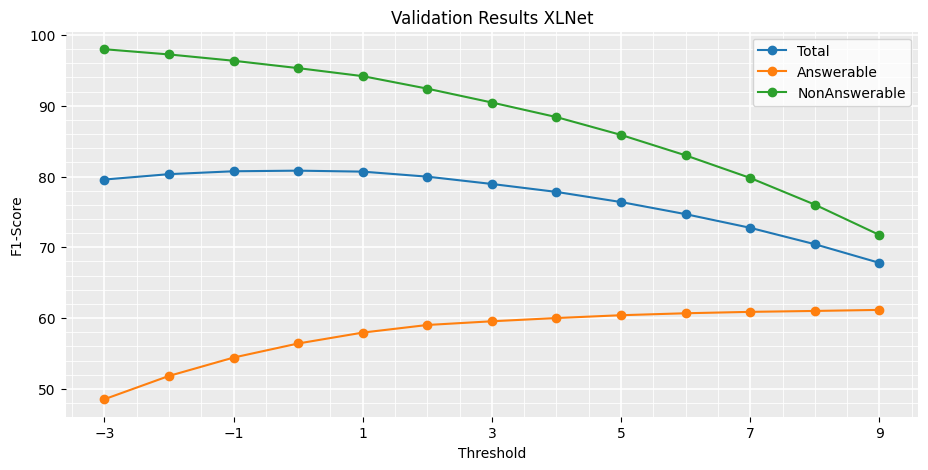

In [64]:
#To determine the threshold
import matplotlib.pyplot as plt

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,5))
ax.title.set_text("Validation Results XLNet")

ax.set_facecolor('#EBEBEB')
# Remove border around plot.
[ax.spines[side].set_visible(False) for side in ax.spines]
# Style the grid.
ax.grid(which='major', color='white', linewidth=1.2)
ax.grid(which='minor', color='white', linewidth=0.6)
# Show the minor ticks and grid.
ax.minorticks_on()
# Now hide the minor ticks (but leave the gridlines).
ax.tick_params(which='minor', bottom=False, left=False)


ax.plot(val_scores["threshold"], val_scores["f1"], "-o", label="Total")
ax.plot(val_scores["threshold"], val_scores["f1_Answ"], "-o", label="Answerable")
ax.plot(val_scores["threshold"], val_scores["f1_NoAnsw"], "-o", label="NonAnswerable")
ax.set_xlabel("Threshold")
ax.set_ylabel("F1-Score")
ax.set_xticks(np.array(val_scores["threshold"])[::2])
ax.legend()
plt.show()

In [65]:
## Pick a threshold with decent f1 and good f1_Answ, like 3 or 4
threshold = 3

In [66]:
best_trainer = Trainer(
    best_model,
    args,
    train_dataset= train_dataset,
    eval_dataset= test_dataset,
    data_collator=data_collator
)

test_predictions = best_trainer.predict(test_dataset)

In [75]:
test_preds_df = get_preds_df(test_predictions, df_test, df_test_tokenized, test_dataset)
test_preds_df[test_preds_df["correct_answer"] == ""].head(20)

,score_diff,pred_start,pred_end,pred_answer,pred_token,start_label,end_label,correct_answer,correct_token,NoAnsw
1,6.458528,122,129,California Unemployment rate: 6.1 percent,"[▁California, ▁Unemployment, ▁rate, :, ▁6, ., ...",0,0,,[],True
3,16.668476,16,135,notoriously rigid immigration laws violate hum...,"[▁notoriously, ▁rigid, ▁immigration, ▁laws, ▁v...",0,0,,[],True
5,10.874613,9,30,Aeroflot official said. He described the weath...,"[▁Aero, flo, t, ▁official, ▁said, ., ▁He, ▁des...",0,0,,[],True
6,16.317999,292,302,inadequate pilot training and weak government ...,"[▁inadequate, ▁pilot, ▁training, ▁and, ▁weak, ...",0,0,,[],True
8,11.345411,120,128,2004 through January 2007 -- only weeks,"[▁2004, ▁through, ▁January, ▁2007, ▁, -, -, ▁o...",0,0,,[],True
11,6.400367,350,355,Each company will provide 10 machines,"[▁Each, ▁company, ▁will, ▁provide, ▁10, ▁machi...",0,0,,[],True
13,19.640835,184,189,author of a 76-page,"[▁author, ▁of, ▁a, ▁76, -, page]",0,0,,[],True
15,7.208346,238,241,billion bond issue raised,"[▁billion, ▁bond, ▁issue, ▁raised]",0,0,,[],True
17,18.487694,238,242,take up by UAE banks,"[▁take, ▁up, ▁by, ▁UAE, ▁banks]",0,0,,[],True
19,9.492517,448,467,"radio-communications loss, concurrent instrume...","[▁radio, -, communication, s, ▁loss, ,, ▁concu...",0,0,,[],True


In [74]:
test_preds_df[test_preds_df["correct_answer"] == ""].head(20)

,score_diff,pred_start,pred_end,pred_answer,pred_token,start_label,end_label,correct_answer,correct_token,NoAnsw
1,6.458528,122,129,California Unemployment rate: 6.1 percent,"[▁California, ▁Unemployment, ▁rate, :, ▁6, ., ...",0,0,,[],True
3,16.668476,16,135,notoriously rigid immigration laws violate hum...,"[▁notoriously, ▁rigid, ▁immigration, ▁laws, ▁v...",0,0,,[],True
5,10.874613,9,30,Aeroflot official said. He described the weath...,"[▁Aero, flo, t, ▁official, ▁said, ., ▁He, ▁des...",0,0,,[],True
6,16.317999,292,302,inadequate pilot training and weak government ...,"[▁inadequate, ▁pilot, ▁training, ▁and, ▁weak, ...",0,0,,[],True
8,11.345411,120,128,2004 through January 2007 -- only weeks,"[▁2004, ▁through, ▁January, ▁2007, ▁, -, -, ▁o...",0,0,,[],True
11,6.400367,350,355,Each company will provide 10 machines,"[▁Each, ▁company, ▁will, ▁provide, ▁10, ▁machi...",0,0,,[],True
13,19.640835,184,189,author of a 76-page,"[▁author, ▁of, ▁a, ▁76, -, page]",0,0,,[],True
15,7.208346,238,241,billion bond issue raised,"[▁billion, ▁bond, ▁issue, ▁raised]",0,0,,[],True
17,18.487694,238,242,take up by UAE banks,"[▁take, ▁up, ▁by, ▁UAE, ▁banks]",0,0,,[],True
19,9.492517,448,467,"radio-communications loss, concurrent instrume...","[▁radio, -, communication, s, ▁loss, ,, ▁concu...",0,0,,[],True


In [76]:
df_test[:20]

,question,narrowed_context,start-end,answer
0,Which states have the highest unemployment rates?,Editor's note: CNN.com has a business partners...,"[(1324, 1351)]",[Carolina Unemployment rate:]
1,Where was Noriko Calderon born?,"TOKYO, Japan (CNN) -- The clicking of dozens o...","[(875, 883)]",[1990s on]
2,What did officials say about terrorism?,"MOSCOW, Russia (CNN) -- A passenger jet caugh...","[(671, 832)]",[it's very doubtful that it was the result of ...
3,In which year ex-playboy found dead in Florida?,"MIAMI, Florida (CNN) -- Prosecutors in Florid...","[(77, 81)]",[2007]
4,what amount of nations defeat opposition,(CNN) -- England and France set themselves on ...,"[(173, 180)]",[Nations]
5,Who will test machines that match boarding pas...,Washington (CNN) -- In a move that could impro...,"[(108, 131)]",[Security Administration]
6,Who was absent from the trial?,(CNN) -- Illinois Gov. Rod Blagojevich was abs...,"[(18, 38)]",[Gov. Rod Blagojevich]
7,How many bodies were recovered?,(CNN) -- The wreckage of a C-130 cargo plane t...,"[(595, 605)]",[pilots and]
8,How much debt does Dubai have?,(CNN) -- Dubai sent investors reeling Thursday...,"[(2774, 2792)]",[loan which expires]
9,What is some of the dialogue delivered as?,"(Entertainment Weekly) -- ""Amelia"" is a frustr...","[(863, 879)]",[speeches -- even]


In [71]:
test_scores_fine_tune = get_f1_df_acc(test_preds_df)
test_scores_fine_tune2 = get_f1_df_em(test_preds_df)

In [72]:
test_scores_fine_tune

,threshold,f1,f1_Answ,f1_NoAnsw,accuracy,accuracy_Answ,accuracy_NoAnsw
0,-3,79.617528,48.295755,97.625297,81.989849,54.794368,97.625297
1,-2,80.443762,51.667793,96.987877,83.260209,59.383020,96.987877
2,-1,80.821901,54.334081,96.050494,84.075866,63.247824,96.050494
3,0,80.653307,56.198331,94.713161,84.303623,66.197816,94.713161
4,1,80.244342,57.599773,93.263342,84.191824,68.413298,93.263342
5,2,79.582715,58.635171,91.626047,83.860568,70.353698,91.626047
6,3,78.553552,59.185501,89.688789,83.067739,71.551429,89.688789
7,4,77.148360,59.662278,87.201600,81.793259,72.386273,87.201600
8,5,75.649374,59.925601,84.689414,80.398814,72.935969,84.689414
9,6,73.756151,60.065490,81.627297,78.610271,73.362614,81.627297


In [73]:
test_scores_fine_tune2

,threshold,f1,f1_Answ,f1_NoAnsw,exact_match,exact_match_Answ,exact_match_NoAnsw
0,-3,79.617528,48.295755,97.625297,74.977496,35.585094,97.625297
1,-2,80.443762,51.667793,96.987877,75.286190,37.539409,96.987877
2,-1,80.821901,54.334081,96.050494,75.218191,38.983571,96.050494
3,0,80.653307,56.198331,94.713161,74.704693,39.903009,94.713161
4,1,80.244342,57.599773,93.263342,74.056745,40.649793,93.263342
5,2,79.582715,58.635171,91.626047,73.207392,41.170946,91.626047
6,3,78.553552,59.185501,89.688789,72.041825,41.347616,89.688789
7,4,77.148360,59.662278,87.201600,70.529176,41.530033,87.201600
8,5,75.649374,59.925601,84.689414,68.992769,41.690845,84.689414
9,6,73.756151,60.065490,81.627297,67.088159,41.799540,81.627297


In [ ]:
#For testing
from transformers import pipeline
qa_model = AutoModelForQuestionAnswering.from_pretrained("/content/drive/MyDrive/STAT8021_QA_Project/xlnet_7/checkpoint-4206")
qa_tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")
qa_model.to(device)
qa_system = pipeline(task='question-answering', model=qa_model, tokenizer=qa_tokenizer, device=torch.cuda.current_device())

In [ ]:
question = "In what city is the carnival?"
context = "(CNN) -- Dancers have put on a dazzling display atop extravagant floats at the legendary annual Rio Carnival. Thousands of revelers cheered as dancers shimmied and shook their colorful costumes through the streets of the Brazilian city. Seven-year-old Julia Lira took her place as the drum corps queen for the Viradouro School of Samba despite criticism that she was too young to fill a role normally reserved for voluptuous adult dancers. @highlight Parade of color during annual Rio Carnival in Brazil @highlight Dancers included seven-year-old Julia Lira, despite criticism that she was too young"
result = qa_system(question=question, context=context)

In [ ]:
print(result['answer'])

Rio Carnival.


In [ ]:
question = "What age is the dancer?"
context = "(CNN) -- Dancers have put on a dazzling display atop extravagant floats at the legendary annual Rio Carnival. Thousands of revelers cheered as dancers shimmied and shook their colorful costumes through the streets of the Brazilian city. Seven-year-old Julia Lira took her place as the drum corps queen for the Viradouro School of Samba despite criticism that she was too young to fill a role normally reserved for voluptuous adult dancers. @highlight Parade of color during annual Rio Carnival in Brazil @highlight Dancers included seven-year-old Julia Lira, despite criticism that she was too young"
result = qa_system(question=question, context=context)
print(result['answer'])

Seven-year-old Julia Lira took
